In [1]:
import sys
sys.path.append("../")

In [ ]:
%load_ext autoreload
%autoreload 2

from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ, RBF

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

import high_dim_power as hd

In [2]:
tf.random.set_seed(1)

DELTA = 0.01

2022-12-22 22:15:28.308868: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-22 22:15:28.308918: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-12-22 22:15:28.308925: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-12-22 22:15:28.309047: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-12-22 22:15:28.309075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-12-22 22:15:28.309082: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-12-22 22:15:28.310230: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

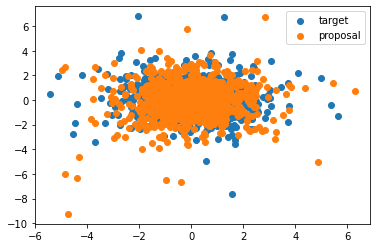

In [3]:
# target, proposal = hd.generate_target_proposal(2, DELTA)
target, proposal = hd.generate_target_proposal_t(2, DELTA, df=5)

target_x = target.sample(1000)
proposal_x = proposal.sample(1000)

fig, ax = plt.subplots()
ax.scatter(target_x[:, 0], target_x[:, 1], label="target")
ax.scatter(proposal_x[:, 0], proposal_x[:, 1], label="proposal")
ax.legend()
plt.show()

In [19]:
# dims = [1, 4, 16, 64, 256]
dims = [4, 16, 64, 128, 192, 256, 512, 1024, 2048]
res_analytical = hd.compute_population_quantities(dims, bandwidth_order=1., kernel_class=RBF)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [21:27<00:00, 143.01s/it]


In [19]:
# res_analytical = hd.compute_population_quantities([4096], bandwidth_order=1., kernel_class=RBF)

tf.random.set_seed(1)
delta = 2
d = 4096
npop = 4000
target_dist, sample_dist = hd.generate_target_proposal(d, delta)
X = sample_dist.sample((npop,))

kernel = RBF(sigma_sq=2.*d**1.)
ksd = KSD(kernel=kernel, log_prob=target_dist.log_prob)

import time
st = time.time()
ksd_val = ksd(X, tf.identity(X)).numpy()
et = time.time()
print("total ellapsed time:", et - st)

2022-12-22 22:29:36.302760: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 262144000000 exceeds 10% of free system memory.


total ellapsed time: 107.05566573143005


In [ ]:
res_analytical2 = hd.compute_population_quantities([4096], bandwidth_order=1., kernel_class=RBF)

In [10]:
## save analytical res
# res_analytical_save = res_analytical
# res_analytical_save["dim"] = dims
# pd.DataFrame(res_analytical_save).to_csv("res/high_dim/res_analytical.csv", index=False)

## load analytical res
# res_analytical_save = pd.read_csv("res/high_dim/res_analytical.csv")
# res_analytical = res_analytical_save.to_dict()

In [20]:
tf.random.set_seed(2022)

# ns = [int(d) for d in dims]
# ns = [500] * len(dims)
ns = [50] * len(dims)

ksd_res = hd.compute_ksd(
    ns=ns,
    dims=dims,
    nreps=100,
    kernel_class=RBF,
    bandwidth_order=1.,
)

Repetition [100/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]


In [8]:
# ksd_res_500 = ksd_res

# Quantile vs. dim

In [10]:
tf.random.set_seed(2022)

btsp_res = hd.bootstrap_quantile(
    dims=dims,
    ns=ns,
    num_boot=1000,
    nreps=100,
    kernel_class=RBF,
    bandwidth_order=1.,
)

In [ ]:
q_res = [np.mean(btsp_res[d]) for d in dims]

figs, axes = plt.subplots(nrows=1, ncols=1)

axes.plot(dims, q_res, marker="x", label="Quantile", color="blue")
axes.plot(dims, res_analytical["ksd"], marker="x", label="KSD")
axes.set_xlabel("Dim")

axes.legend()

# Power vs. dim

In [13]:
ts_l = np.array(res_analytical["ksd"]) * (1 - 0.2)
# ts_l = q_res # use quantiles from indep samples
ts_u = np.array(res_analytical["ksd"]) * (1 + 0.2)

res = hd.power_experiment(
    ksd_res,
    res_analytical,
    ns,
    dims,
    ts_lb=ts_l,
    ts_ub=ts_u,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13400.33it/s]


Text(0.5, 1.0, 'upper bound')

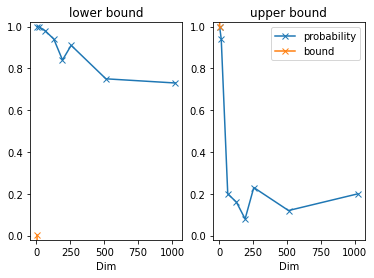

In [14]:
figs, axes = plt.subplots(nrows=1, ncols=2)

axes[0].plot(res["dim"], res["probs_l"], marker="x", label="probability")
axes[0].plot(res["dim"], res["l_bd"], marker="x", label="bound")
axes[0].set_xlabel("Dim")
axes[0].set_ylim(-0.02, 1.02)
# axes[0].legend()
axes[0].set_title("lower bound")

axes[1].plot(res["dim"], res["probs_u"], marker="x", label="probability")
axes[1].plot(res["dim"], res["u_bd"], marker="x", label="bound")
axes[1].set_xlabel("Dim")
axes[1].set_ylim(-0.02, 1.02)
axes[1].legend()
axes[1].set_title("upper bound")

In [13]:
# BE bound
res_be = hd.power_experiment(
    ksd_res,
    res_analytical,
    ns,
    dims,
    ts_lb=ts_l,
    ts_ub=ts_u,
    bound="be",
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 3548.81it/s]


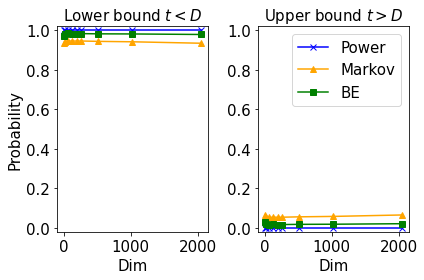

In [14]:
figs, axes = plt.subplots(nrows=1, ncols=2)

axes[0].plot(res_be["dim"], res_be["probs_l"], marker="x", label="Power", color="blue")
axes[0].plot(res["dim"], res["l_bd"], marker="^", label="Markov", color="orange")
axes[0].plot(res_be["dim"], res_be["l_bd"], marker="s", label="BE", color="green")
axes[0].set_xlabel("Dim", fontsize=15)
axes[0].set_ylabel("Probability", fontsize=15)
axes[0].set_title("Lower bound $t < D$", fontsize=15)
axes[0].set_ylim(-0.02, 1.02)
axes[0].tick_params(labelsize=15)

axes[1].plot(res_be["dim"], res_be["probs_u"], marker="x", label="Power", color="blue")
axes[1].plot(res["dim"], res["u_bd"], marker="^", label="Markov", color="orange")
axes[1].plot(res_be["dim"], res_be["u_bd"], marker="s", label="BE", color="green")
axes[1].set_xlabel("Dim", fontsize=15)
axes[1].set_title("Upper bound $t > D$", fontsize=15)
axes[1].set_ylim(-0.02, 1.02)
axes[1].tick_params(labelsize=15)
axes[1].legend(fontsize=15)
plt.tight_layout()

# figs.savefig("figs/power_dim.pdf")

# Fixed n, d, varying t

In [199]:
i = -1
d = dims[i]
print("dim chosen:", d)

res_analytical_d = {
    k: v[i] for k, v in res_analytical.items()
}

ts_l = res_analytical_d["ksd"] * (1 - np.linspace(0., 0.9, 51))
ts_u = res_analytical_d["ksd"] * (1 + np.linspace(0., 0.9, 51))

res = hd.power_experiment_t(
    ksd_vals=ksd_res[d],
    res_analytical=res_analytical_d,
    n=ns[i],
    ts_lb=ts_l,
    ts_ub=ts_u,
)

dim chosen: 2048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 24146.01it/s]


In [200]:
# Berry-Esseen
res_be = hd.power_experiment_t(
    ksd_vals=ksd_res[d],
    res_analytical=res_analytical_d,
    n=ns[i],
    ts_lb=ts_l,
    ts_ub=ts_u,
    bound="be",
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 4582.56it/s]


In [201]:
# new surrogate full
res_new_full = hd.power_experiment_t(
    ksd_vals=ksd_res[d],
    res_analytical=res_analytical_d,
    n=ns[i],
    ts_lb=ts_l,
    ts_ub=ts_u,
    bound="new_full",
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 5545.58it/s]


In [202]:
# new surrogate cond
res_new_cond = hd.power_experiment_t(
    ksd_vals=ksd_res[d],
    res_analytical=res_analytical_d,
    n=ns[i],
    ts_lb=ts_l,
    ts_ub=ts_u,
    bound="new_cond",
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 5337.73it/s]


In [203]:
# new surrogate sum
res_new_sum = hd.power_experiment_t(
    ksd_vals=ksd_res[d],
    res_analytical=res_analytical_d,
    n=ns[i],
    ts_lb=ts_l,
    ts_ub=ts_u,
    bound="new_sum",
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 5202.33it/s]


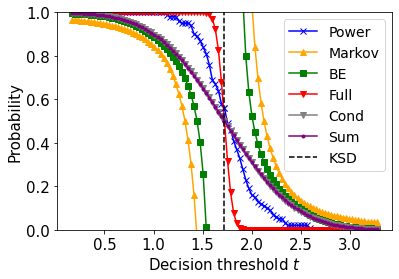

In [198]:
figs, axes = plt.subplots(nrows=1, ncols=1)

# empirical probs
axes.plot(res_be["t_l"], res_be["probs_l"], marker="x", label="Power", color="blue")
axes.plot(res["t_u"], res["probs_u"], marker="x", color="blue")

# markov bound
axes.plot(res["t_l"], res["l_bd"], marker="^", label="Markov", color="orange")
axes.plot(res["t_u"], res["u_bd"], marker="^", color="orange")

# BE bound
axes.plot(res_be["t_l"], res_be["l_bd"], marker="s", label="BE", color="green")
axes.plot(res_be["t_u"], res_be["u_bd"], marker="s", color="green")

# new full bound
axes.plot(res_new_full["t_l"], res_new_full["l_bd"], marker="v", label="Full", color="red")
axes.plot(res_new_full["t_u"], res_new_full["u_bd"], marker="v", color="red")

# new cond bound
axes.plot(res_new_cond["t_l"], res_new_cond["l_bd"], marker="v", label="Cond", color="grey")
axes.plot(res_new_cond["t_u"], res_new_cond["u_bd"], marker="v", color="grey")

# new sum bound
axes.plot(res_new_sum["t_l"], res_new_sum["l_bd"], marker=".", label="Sum", color="purple")
axes.plot(res_new_sum["t_u"], res_new_sum["u_bd"], marker=".", color="purple")

axes.axvline(res_analytical_d["ksd"], color="k", linestyle="--", label="KSD")

axes.set_xlabel("Decision threshold $t$", fontsize=15)
axes.set_ylabel("Probability", fontsize=15)
# axes.set_xlim(1., 2.4)
axes.set_ylim(0., 1.)
axes.tick_params(labelsize=15)
axes.legend(fontsize=14)

# figs.savefig("figs/power_t.pdf")

In [204]:
print(f"d={d}")
print(res_analytical_d["cond_var"])
print(res_analytical_d["full_var"])

d=2048
2.4318829
280.04866538982947


In [205]:
print(f"d={d}")
print(res_analytical_d["cond_var"])
print(res_analytical_d["full_var"] / ns[i])

d=2048
2.4318829
5.60097330779659


Text(0.5, 1.0, 'dim = 2048')

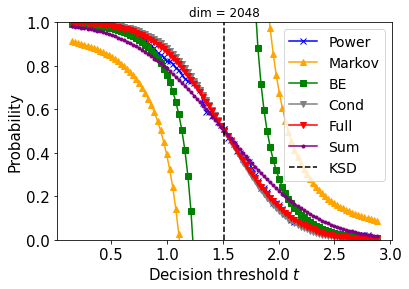

In [206]:
figs, axes = plt.subplots(nrows=1, ncols=1)

# empirical probs
axes.plot(res_be["t_l"], res_be["probs_l"], marker="x", label="Power", color="blue")
axes.plot(res["t_u"], res["probs_u"], marker="x", color="blue")

# markov bound
axes.plot(res["t_l"], res["l_bd"], marker="^", label="Markov", color="orange")
axes.plot(res["t_u"], res["u_bd"], marker="^", color="orange")

# BE bound
axes.plot(res_be["t_l"], res_be["l_bd"], marker="s", label="BE", color="green")
axes.plot(res_be["t_u"], res_be["u_bd"], marker="s", color="green")

# new cond bound
axes.plot(res_new_cond["t_l"], res_new_cond["l_bd"], marker="v", label="Cond", color="grey")
axes.plot(res_new_cond["t_u"], res_new_cond["u_bd"], marker="v", color="grey")

# new full bound
axes.plot(res_new_full["t_l"], res_new_full["l_bd"], marker="v", label="Full", color="red")
axes.plot(res_new_full["t_u"], res_new_full["u_bd"], marker="v", color="red")

# new sum bound
axes.plot(res_new_sum["t_l"], res_new_sum["l_bd"], marker=".", label="Sum", color="purple")
axes.plot(res_new_sum["t_u"], res_new_sum["u_bd"], marker=".", color="purple")

axes.axvline(res_analytical_d["ksd"], color="k", linestyle="--", label="KSD")

axes.set_xlabel("Decision threshold $t$", fontsize=15)
axes.set_ylabel("Probability", fontsize=15)
# axes.set_xlim(1., 2.4)
axes.set_ylim(0., 1.)
axes.tick_params(labelsize=15)
axes.legend(fontsize=14)
axes.set_title(f"dim = {d}")

# figs.savefig("figs/power_t.pdf")

# Moments vs. dim

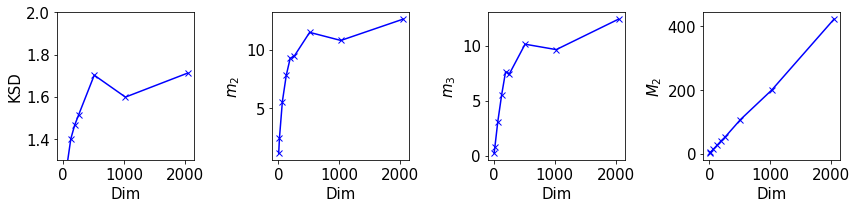

In [21]:
ksd_vals = np.array(res_analytical["ksd"])
m2_vals = np.array(res_analytical["cond_var"])
M2_vals = np.array(res_analytical["full_var"])
m3_vals = np.array(res_analytical["m3"])

m2_d2 = m2_vals / ksd_vals**2
M2_d2 = M2_vals / ksd_vals**2
m3_d3 = m3_vals / ksd_vals**3

figs, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

axes[0].plot(dims, ksd_vals, marker="x", label="$m_2 / D^2$", color="blue")
axes[0].set_xlabel("Dim", fontsize=15)
axes[0].set_ylabel("KSD", fontsize=15)
axes[0].set_ylim(1.3, 2.)
axes[0].tick_params(labelsize=15)

axes[1].plot(dims, m2_vals, marker="x", label="$m_3 / D^3$", color="blue")
axes[1].set_xlabel("Dim", fontsize=15)
axes[1].set_ylabel("$m_2$", fontsize=15)
axes[1].tick_params(labelsize=15)

axes[2].plot(dims, m3_vals, marker="x", label="$m_3 / D^3$", color="blue")
axes[2].set_xlabel("Dim", fontsize=15)
axes[2].set_ylabel("$m_3$", fontsize=15)
axes[2].tick_params(labelsize=15)

axes[3].plot(dims, M2_vals, marker="x", label="$M_2 / D^2$", color="blue")
axes[3].set_xlabel("Dim", fontsize=15)
axes[3].set_ylabel("$M_2$", fontsize=15)
axes[3].tick_params(labelsize=15)

plt.tight_layout()

# figs.savefig("figs/moments_dim.pdf")

# Kernels

In [85]:
from src.ksd.kernel import RBF, IMQ
import seaborn as sns
import pandas as pd

In [109]:
xx = tf.expand_dims(tf.linspace(-6., 6., 100), -1)
yy = tf.zeros((100, 1))

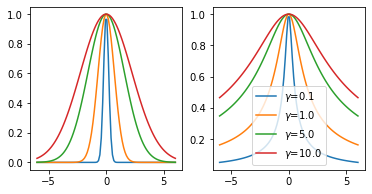

In [110]:
bandwidths = [0.1, 1., 5., 10.]
kk_all = []

figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
for b in bandwidths:
    k_rbf = RBF(sigma_sq=tf.constant(b))
    kk_rbf = k_rbf(xx, yy)[:, 0].numpy()

    k_imq = IMQ(sigma_sq=tf.constant(b))
    kk_imq = k_imq(xx, yy)[:, 0].numpy()
    
    plot_xx = xx[:, 0]
    axes[0].plot(xx, kk_rbf, label=f"$\gamma$={b}")
    axes[1].plot(xx, kk_imq, label=f"$\gamma$={b}")
    
axes[1].legend()

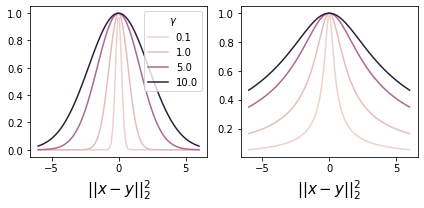

In [111]:
bandwidths = [0.1, 1., 5., 10.]
xx_plot = xx[:, 0]
res_rbf = {"x": [], "y": [], "b": []}
res_imq = {"x": [], "y": [], "b": []}

for b in bandwidths:
    k_rbf = RBF(sigma_sq=tf.constant(b))
    kk_rbf = k_rbf(xx, yy)[:, 0].numpy()

    k_imq = IMQ(sigma_sq=tf.constant(b))
    kk_imq = k_imq(xx, yy)[:, 0].numpy()
        
    res_rbf["x"] += list(xx_plot.numpy())
    res_rbf["y"] += list(kk_rbf)
    res_rbf["b"] += [b] * len(xx_plot)
    
    res_imq["x"] += list(xx_plot.numpy())
    res_imq["y"] += list(kk_imq)
    res_imq["b"] += [b] * len(xx_plot)
    
res_rbf = pd.DataFrame(res_rbf)
res_imq = pd.DataFrame(res_imq)

figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

sns.lineplot(ax=axes[0], data=res_rbf, x="x", y="y", hue="b")
axes[0].legend(title="$\gamma$")
axes[0].set_xlabel(f"$|| x - y ||_2^2$", fontsize=15)
axes[0].set_ylabel("")

sns.lineplot(ax=axes[1], data=res_imq, x="x", y="y", hue="b")
axes[1].legend([],[], frameon=False)
axes[1].set_xlabel(f"$|| x - y ||_2^2$", fontsize=15)
axes[1].set_ylabel("")

plt.tight_layout()

In [ ]:
plt.figure()
sns.lineplot(data=res_rbf, x="x", y="y", hue="b")
plt.legend(title="$\gamma$")
plt.xlabel(f"$|| x - y ||_2^2$", fontsize=15)
plt.ylabel("")
plt.savefig("figs/rbf.pdf")

plt.figure()
sns.lineplot(data=res_imq, x="x", y="y", hue="b")
plt.legend([],[], frameon=False)
plt.xlabel(f"$|| x - y ||_2^2$", fontsize=15)
plt.ylabel("")
plt.savefig("figs/imq.pdf")
